<a href="https://colab.research.google.com/github/AliFirouzi/AliFirouzi/blob/main/NDVI_Index_Calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/sentinel-hub/sentinelhub-py


  Cloning https://github.com/sentinel-hub/sentinelhub-py to /tmp/pip-req-build-xmiqca9q
  Running command git clone --filter=blob:none --quiet https://github.com/sentinel-hub/sentinelhub-py /tmp/pip-req-build-xmiqca9q
  Resolved https://github.com/sentinel-hub/sentinelhub-py to commit 4f4fd88d6613f6c21278f644cf1ed78b388bbaea
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for sentinelhub: filename=sentinelhub-3.11.1-py3-none-any.whl size=249768 sha256=2eee4e02d5dbbcbbff03db28ec67d050beede565a736c94405f07d92d6efca6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-z3k841hg/wheels/2c/6a/32/aaeb77a3e79db0bb617707ff8e5612856e9b514538b7493192
Successfully built sentinelhub


In [ ]:
# Step 1: Install the required package
!pip install requests-oauthlib

# Step 2: Authenticate with your credentials
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

# Your client credentials
client_id = 'sh-c28e91ef-db7f-46dd-8241-9524125beeb6'
client_secret = 'Ccjhf36JjGsYe2k57WyQmjPsst3eWQEC'

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Request an access token
token = oauth.fetch_token(
    token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
    client_secret=client_secret,
    include_client_id=True
)

print("✅ OAuth2 token obtained successfully!")
print("Access Token (truncated):", token['access_token'][:60] + "...")

# Step 3: Test an actual API call
response = oauth.get("https://sh.dataspace.copernicus.eu/configuration/v1/wms/instances")

print("\n✅ WMS Instances Response:")
print(response.status_code)
print(response.content[:500])  # Show first 500 chars


✅ OAuth2 token obtained successfully!
Access Token (truncated): eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJYVUh3VWZK...

✅ WMS Instances Response:
200
b'[{"@id":"https://sh.dataspace.copernicus.eu/configuration/v1/wms/instances/75c02082-a5a9-4c2f-9cb8-56d272378539","id":"75c02082-a5a9-4c2f-9cb8-56d272378539","name":"Ali","domainAccountId":"fff0fa25-f0e5-41aa-b5d8-27ea6ff89fbe","additionalData":{"showWarnings":true,"showLogo":true,"imageQuality":90},"created":"2025-07-03T22:24:06.896683Z","lastUpdated":"2025-07-03T22:24:06.896683Z","layers":{"@id":"https://sh.dataspace.copernicus.eu/configuration/v1/wms/instances/75c02082-a5a9-4c2f-9cb8-56d272378'


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


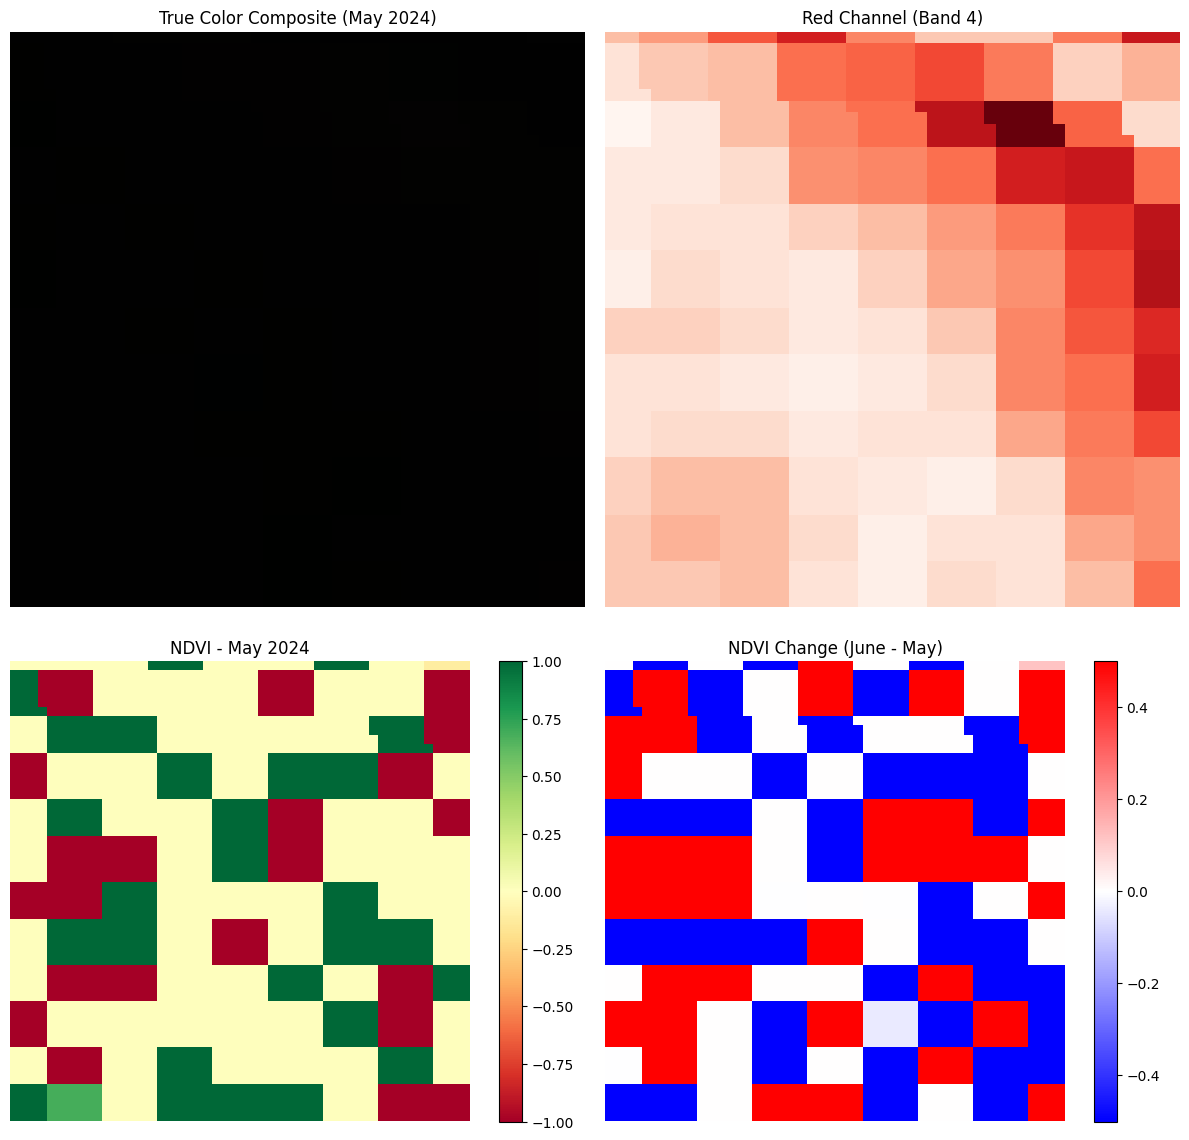

In [ ]:
# Install required packages
# !pip install requests requests-oauthlib numpy matplotlib pillow

# Import packages
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# Auth setup
client_id = 'sh-c28e91ef-db7f-46dd-8241-9524125beeb6'
client_secret = 'Ccjhf36JjGsYe2k57WyQmjPsst3eWQEC'
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)
token = oauth.fetch_token(
    token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
    client_secret=client_secret,
    include_client_id=True
)
access_token = token['access_token']

# Define area (adjustable: 100m² small farmland)
bbox = [2.07, 41.52, 2.071, 41.521]  # You can modify to your area

# Helper function to request imagery
def get_image(evalscript, from_date, to_date, width=50, height=50):
    url = "https://sh.dataspace.copernicus.eu/api/v1/process"
    payload = {
        "input": {
            "bounds": {
                "bbox": bbox,
                "properties": {"crs": "http://www.opengis.net/def/crs/EPSG/0/4326"}
            },
            "data": [{
                "type": "sentinel-2-l2a",
                "dataFilter": {
                    "timeRange": {"from": from_date, "to": to_date}
                }
            }]
        },
        "output": {
            "width": width,
            "height": height,
            "responses": [{
                "identifier": "default",
                "format": {"type": "image/tiff"}
            }]
        },
        "evalscript": evalscript
    }
    headers = {
        "Authorization": f"Bearer {access_token}",
        "Content-Type": "application/json"
    }
    response = requests.post(url, json=payload, headers=headers)
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
        return np.array(image)
    else:
        print("❌ Error:", response.status_code, response.text)
        return None

# Evalscripts
evalscript_rgb = """
//VERSION=3
function setup() {
  return {
    input: ["B04", "B03", "B02"],
    output: { bands: 3 }
  };
}
function evaluatePixel(sample) {
  return [sample.B04, sample.B03, sample.B02];
}
"""

evalscript_red = """
//VERSION=3
function setup() {
  return {
    input: ["B04"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  return [sample.B04];
}
"""

evalscript_ndvi = """
//VERSION=3
function setup() {
  return {
    input: ["B04", "B08"],
    output: { bands: 1, sampleType: "FLOAT32" }
  };
}
function evaluatePixel(sample) {
  let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
  return [ndvi];
}
"""

# Dates
date1 = ("2024-05-01T00:00:00Z", "2024-05-31T23:59:59Z")
date2 = ("2024-06-01T00:00:00Z", "2024-06-30T23:59:59Z")

# Fetch imagery
rgb_img = get_image(evalscript_rgb, *date1)
red_img = get_image(evalscript_red, *date1)
ndvi_may = get_image(evalscript_ndvi, *date1)
ndvi_june = get_image(evalscript_ndvi, *date2)

# NDVI change (June - May)
ndvi_change = ndvi_june - ndvi_may

# Plot all views
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

axs[0, 0].imshow(rgb_img / 3000)  # Normalize for better display
axs[0, 0].set_title('True Color Composite (May 2024)')
axs[0, 0].axis('off')

axs[0, 1].imshow(red_img, cmap='Reds')
axs[0, 1].set_title('Red Channel (Band 4)')
axs[0, 1].axis('off')

im_ndvi = axs[1, 0].imshow(ndvi_may, cmap='RdYlGn', vmin=-1, vmax=1)
axs[1, 0].set_title('NDVI - May 2024')
axs[1, 0].axis('off')
fig.colorbar(im_ndvi, ax=axs[1, 0], shrink=0.8)

im_diff = axs[1, 1].imshow(ndvi_change, cmap='bwr', vmin=-0.5, vmax=0.5)
axs[1, 1].set_title('NDVI Change (June - May)')
axs[1, 1].axis('off')
fig.colorbar(im_diff, ax=axs[1, 1], shrink=0.8)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


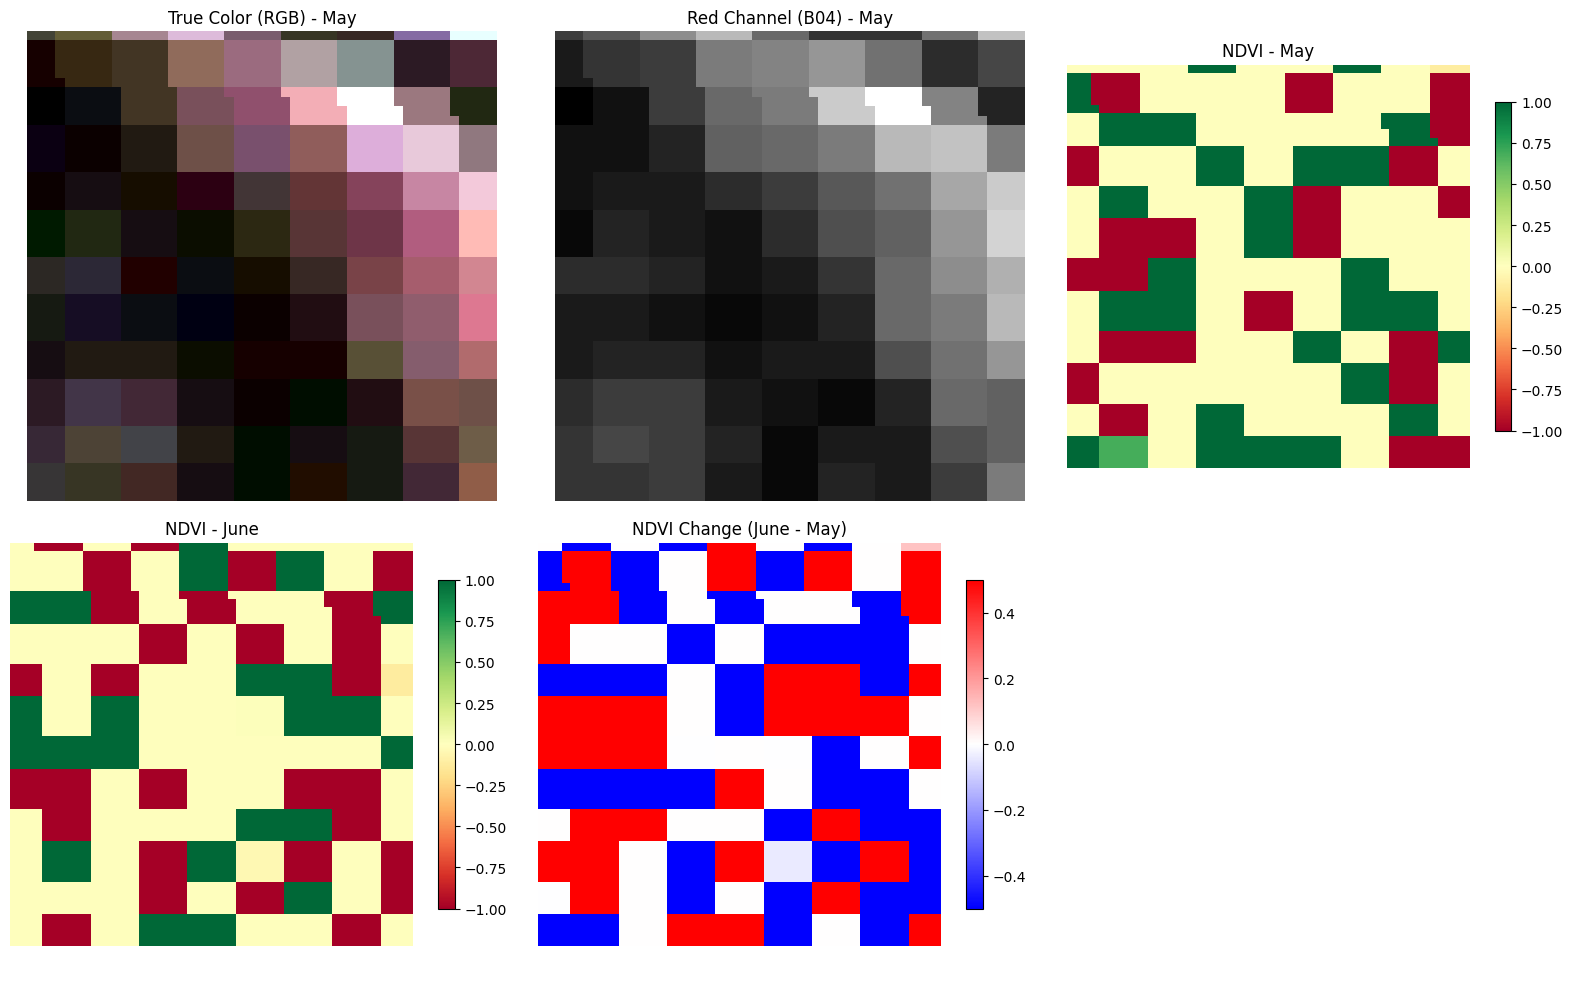

In [ ]:
# Install required packages
# !pip install requests requests-oauthlib numpy matplotlib pillow

from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# Auth credentials
client_id = 'sh-c28e91ef-db7f-46dd-8241-9524125beeb6'
client_secret = 'Ccjhf36JjGsYe2k57WyQmjPsst3eWQEC'
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)
token = oauth.fetch_token(
    token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
    client_secret=client_secret,
    include_client_id=True
)
access_token = token['access_token']

# Define bounding box (~100m² area)
bbox = [2.07, 41.52, 2.071, 41.521]

# Helper to request image
def get_image(evalscript, from_date, to_date, width=50, height=50):
    url = "https://sh.dataspace.copernicus.eu/api/v1/process"
    payload = {
        "input": {
            "bounds": {
                "bbox": bbox,
                "properties": {"crs": "http://www.opengis.net/def/crs/EPSG/0/4326"}
            },
            "data": [{
                "type": "sentinel-2-l2a",
                "dataFilter": {"timeRange": {"from": from_date, "to": to_date}}
            }]
        },
        "output": {
            "width": width,
            "height": height,
            "responses": [{
                "identifier": "default",
                "format": {"type": "image/tiff"}
            }]
        },
        "evalscript": evalscript
    }
    headers = {"Authorization": f"Bearer {access_token}", "Content-Type": "application/json"}
    response = requests.post(url, json=payload, headers=headers)
    if response.status_code == 200:
        return np.array(Image.open(BytesIO(response.content)))
    else:
        print("❌ Error:", response.status_code, response.text)
        return None

# EvalScripts
evalscript_rgb = """
//VERSION=3
function setup() {
  return {
    input: ["B04", "B03", "B02"],
    output: { bands: 3 }
  };
}
function evaluatePixel(sample) {
  return [sample.B04, sample.B03, sample.B02];
}
"""

evalscript_red = """
//VERSION=3
function setup() {
  return {
    input: ["B04"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  return [sample.B04];
}
"""

evalscript_ndvi = """
//VERSION=3
function setup() {
  return {
    input: ["B04", "B08"],
    output: { bands: 1, sampleType: "FLOAT32" }
  };
}
function evaluatePixel(sample) {
  let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
  return [ndvi];
}
"""

# Dates
may = ("2024-05-01T00:00:00Z", "2024-05-31T23:59:59Z")
june = ("2024-06-01T00:00:00Z", "2024-06-30T23:59:59Z")

# Get images
rgb_img = get_image(evalscript_rgb, *may)
red_img = get_image(evalscript_red, *may)
ndvi_may = get_image(evalscript_ndvi, *may)
ndvi_june = get_image(evalscript_ndvi, *june)

# Normalize RGB for display using percentiles
def normalize_rgb(img):
    norm_img = np.zeros_like(img, dtype=np.float32)
    for i in range(3):
        band = img[:, :, i]
        min_val, max_val = np.percentile(band, (1, 99))
        norm_img[:, :, i] = np.clip((band - min_val) / (max_val - min_val), 0, 1)
    return norm_img

rgb_norm = normalize_rgb(rgb_img)
ndvi_diff = ndvi_june - ndvi_may

# Plot everything
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

axs[0, 0].imshow(rgb_norm)
axs[0, 0].set_title("True Color (RGB) - May")
axs[0, 0].axis('off')

axs[0, 1].imshow(red_img, cmap='gray')
axs[0, 1].set_title("Red Channel (B04) - May")
axs[0, 1].axis('off')

im1 = axs[0, 2].imshow(ndvi_may, cmap='RdYlGn', vmin=-1, vmax=1)
axs[0, 2].set_title("NDVI - May")
axs[0, 2].axis('off')
fig.colorbar(im1, ax=axs[0, 2], shrink=0.7)

im2 = axs[1, 0].imshow(ndvi_june, cmap='RdYlGn', vmin=-1, vmax=1)
axs[1, 0].set_title("NDVI - June")
axs[1, 0].axis('off')
fig.colorbar(im2, ax=axs[1, 0], shrink=0.7)

im3 = axs[1, 1].imshow(ndvi_diff, cmap='bwr', vmin=-0.5, vmax=0.5)
axs[1, 1].set_title("NDVI Change (June - May)")
axs[1, 1].axis('off')
fig.colorbar(im3, ax=axs[1, 1], shrink=0.7)

axs[1, 2].axis('off')  # Empty cell

plt.tight_layout()
plt.show()


/tmp/ipython-input-6-1010569975.py:121: RuntimeWarning: invalid value encountered in subtract
  ndvi_diff = ndvi_june - ndvi_may


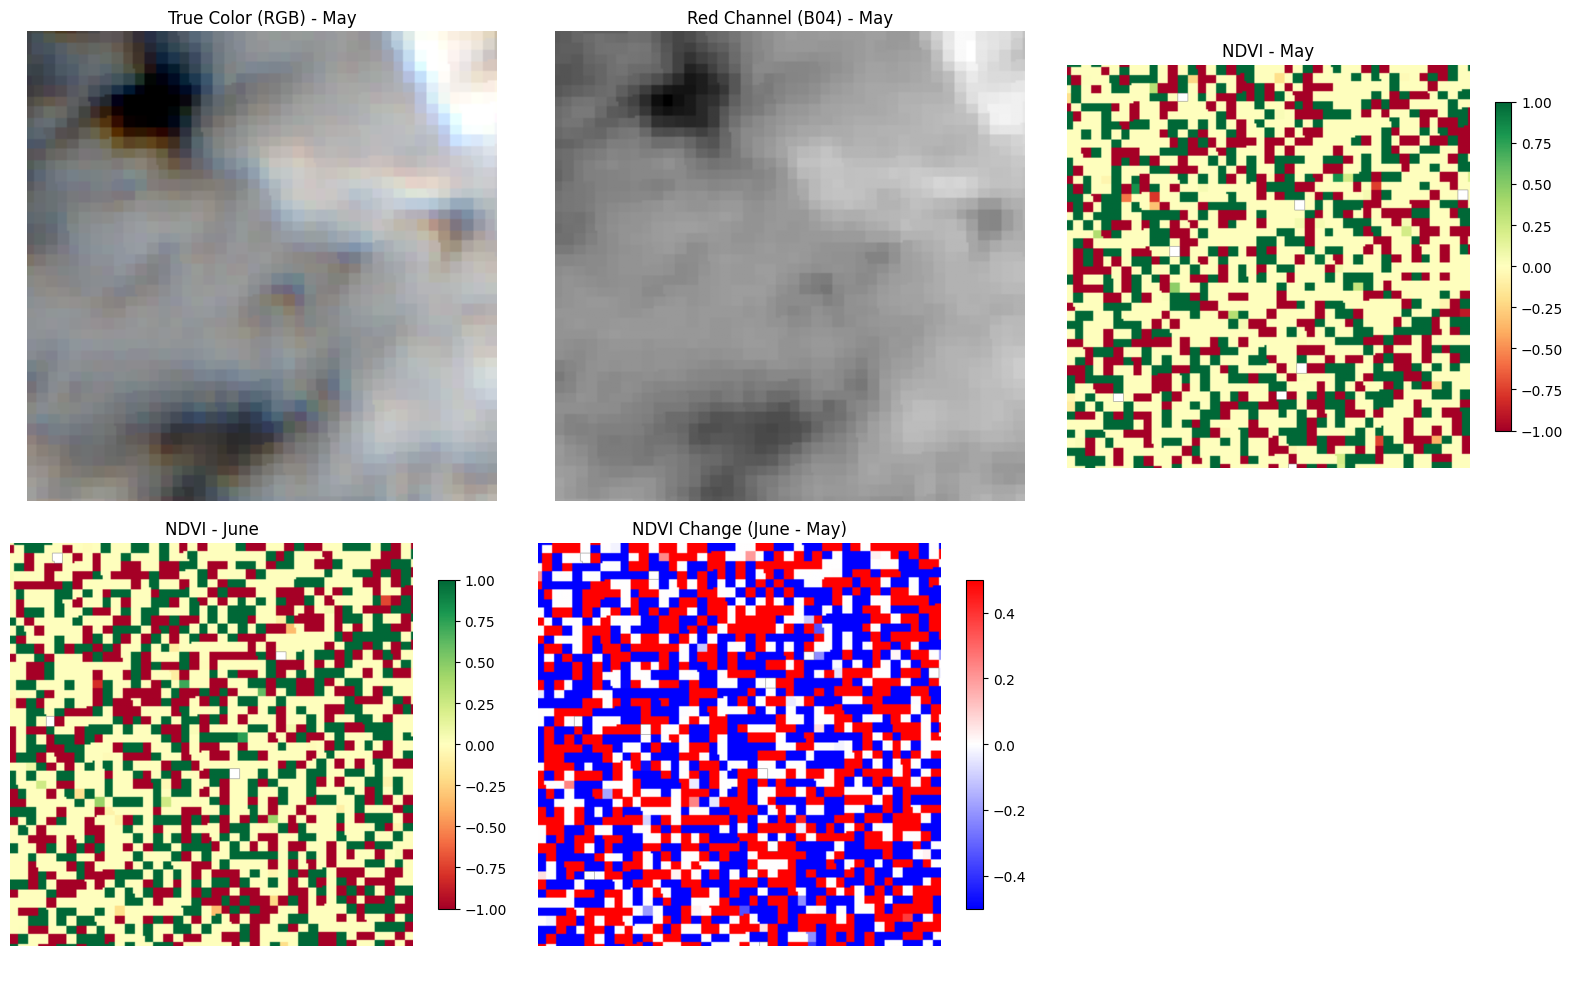

In [ ]:
# Install required packages
# !pip install requests requests-oauthlib numpy matplotlib pillow

from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# Auth credentials
client_id = 'sh-c28e91ef-db7f-46dd-8241-9524125beeb6'
client_secret = 'Ccjhf36JjGsYe2k57WyQmjPsst3eWQEC'
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)
token = oauth.fetch_token(
    token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
    client_secret=client_secret,
    include_client_id=True
)
access_token = token['access_token']

# Define bounding box (~300*300 m² area)
bbox = [2.1525, 41.4135, 2.1575, 41.4175]


# Helper to request image
def get_image(evalscript, from_date, to_date, width=50, height=50):
    url = "https://sh.dataspace.copernicus.eu/api/v1/process"
    payload = {
        "input": {
            "bounds": {
                "bbox": bbox,
                "properties": {"crs": "http://www.opengis.net/def/crs/EPSG/0/4326"}
            },
            "data": [{
                "type": "sentinel-2-l2a",
                "dataFilter": {"timeRange": {"from": from_date, "to": to_date}}
            }]
        },
        "output": {
            "width": width,
            "height": height,
            "responses": [{
                "identifier": "default",
                "format": {"type": "image/tiff"}
            }]
        },
        "evalscript": evalscript
    }
    headers = {"Authorization": f"Bearer {access_token}", "Content-Type": "application/json"}
    response = requests.post(url, json=payload, headers=headers)
    if response.status_code == 200:
        return np.array(Image.open(BytesIO(response.content)))
    else:
        print("❌ Error:", response.status_code, response.text)
        return None

# EvalScripts
evalscript_rgb = """
//VERSION=3
function setup() {
  return {
    input: ["B04", "B03", "B02"],
    output: { bands: 3 }
  };
}
function evaluatePixel(sample) {
  return [sample.B04, sample.B03, sample.B02];
}
"""

evalscript_red = """
//VERSION=3
function setup() {
  return {
    input: ["B04"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  return [sample.B04];
}
"""

evalscript_ndvi = """
//VERSION=3
function setup() {
  return {
    input: ["B04", "B08"],
    output: { bands: 1, sampleType: "FLOAT32" }
  };
}
function evaluatePixel(sample) {
  let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
  return [ndvi];
}
"""

# Dates
may = ("2024-05-01T00:00:00Z", "2024-05-31T23:59:59Z")
june = ("2024-06-01T00:00:00Z", "2024-06-30T23:59:59Z")

# Get images
rgb_img = get_image(evalscript_rgb, *may, width=200, height=200)
red_img = get_image(evalscript_red, *may, width=200, height=200)
ndvi_may = get_image(evalscript_ndvi, *may, width=200, height=200)
ndvi_june = get_image(evalscript_ndvi, *june, width=200, height=200)

# Normalize RGB for display using percentiles
def normalize_rgb(img):
    norm_img = np.zeros_like(img, dtype=np.float32)
    for i in range(3):
        band = img[:, :, i]
        min_val, max_val = np.percentile(band, (1, 99))
        norm_img[:, :, i] = np.clip((band - min_val) / (max_val - min_val), 0, 1)
    return norm_img

rgb_norm = normalize_rgb(rgb_img)
ndvi_diff = ndvi_june - ndvi_may

# Plot everything
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

axs[0, 0].imshow(rgb_norm)
axs[0, 0].set_title("True Color (RGB) - May")
axs[0, 0].axis('off')

axs[0, 1].imshow(red_img, cmap='gray')
axs[0, 1].set_title("Red Channel (B04) - May")
axs[0, 1].axis('off')

im1 = axs[0, 2].imshow(ndvi_may, cmap='RdYlGn', vmin=-1, vmax=1)
axs[0, 2].set_title("NDVI - May")
axs[0, 2].axis('off')
fig.colorbar(im1, ax=axs[0, 2], shrink=0.7)

im2 = axs[1, 0].imshow(ndvi_june, cmap='RdYlGn', vmin=-1, vmax=1)
axs[1, 0].set_title("NDVI - June")
axs[1, 0].axis('off')
fig.colorbar(im2, ax=axs[1, 0], shrink=0.7)

im3 = axs[1, 1].imshow(ndvi_diff, cmap='bwr', vmin=-0.5, vmax=0.5)
axs[1, 1].set_title("NDVI Change (June - May)")
axs[1, 1].axis('off')
fig.colorbar(im3, ax=axs[1, 1], shrink=0.7)

axs[1, 2].axis('off')  # Empty cell

plt.tight_layout()
plt.show()


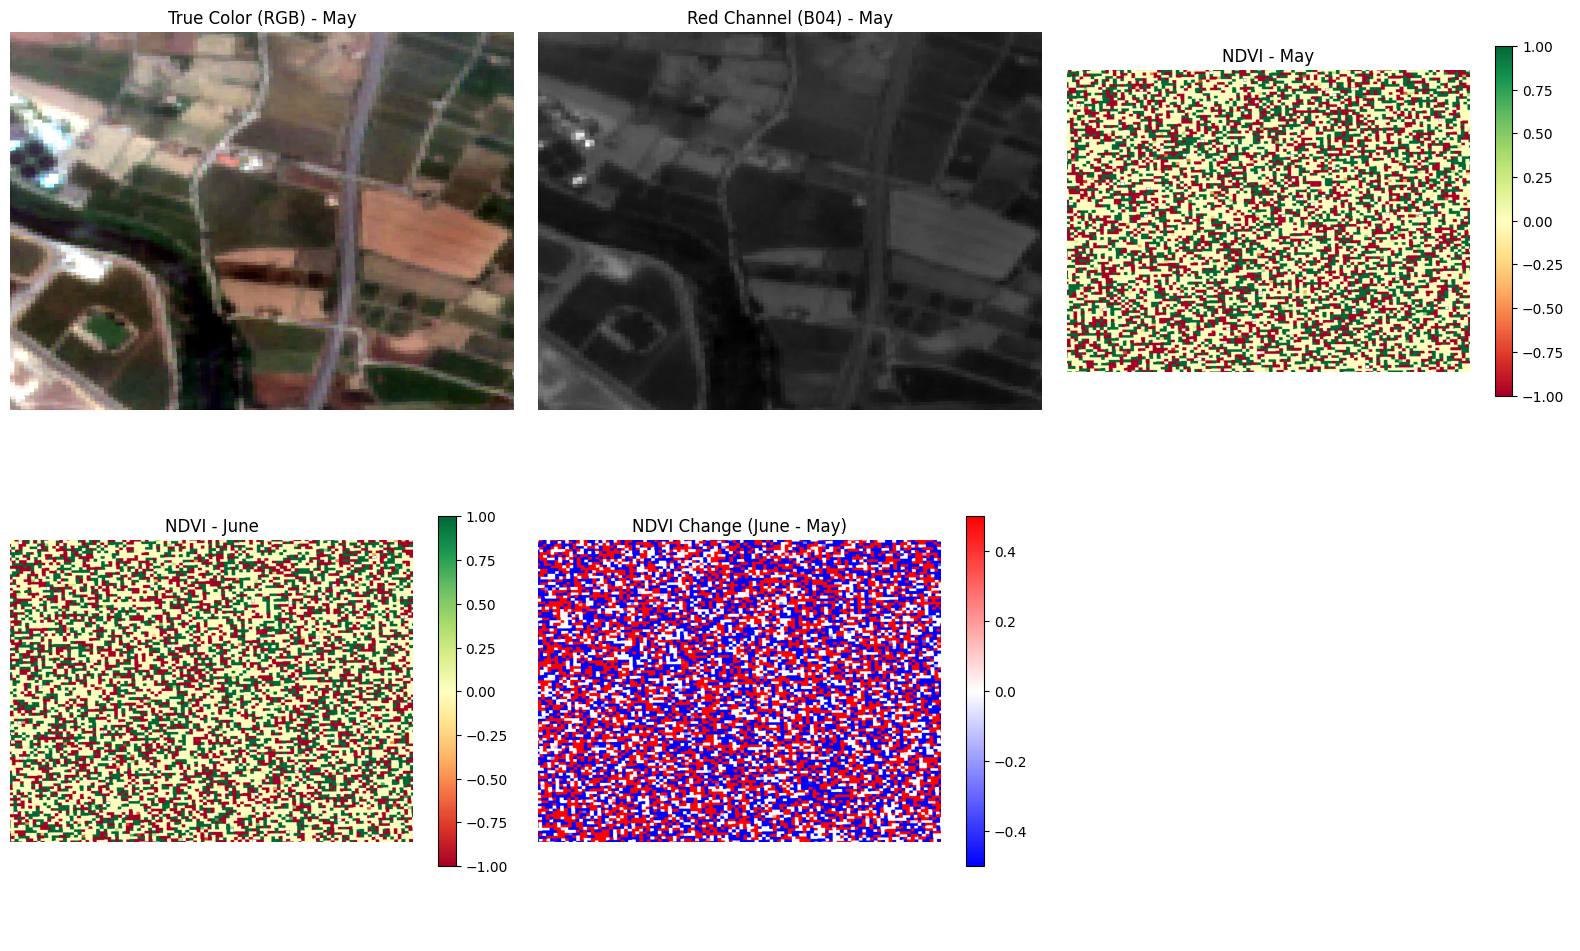

In [ ]:
# Install required packages
# !pip install requests requests-oauthlib numpy matplotlib pillow

from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# Auth credentials
client_id = 'sh-c28e91ef-db7f-46dd-8241-9524125beeb6'
client_secret = 'Ccjhf36JjGsYe2k57WyQmjPsst3eWQEC'
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)
token = oauth.fetch_token(
    token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
    client_secret=client_secret,
    include_client_id=True
)
access_token = token['access_token']

# Define bounding box (~300*300 m² area)
bbox = [0.617, 41.590, 0.630, 41.600]



# Helper to request image
def get_image(evalscript, from_date, to_date, width=50, height=50):
    url = "https://sh.dataspace.copernicus.eu/api/v1/process"
    payload = {
        "input": {
            "bounds": {
                "bbox": bbox,
                "properties": {"crs": "http://www.opengis.net/def/crs/EPSG/0/4326"}
            },
            "data": [{
                "type": "sentinel-2-l2a",
                "dataFilter": {"timeRange": {"from": from_date, "to": to_date}}
            }]
        },
        "output": {
            "width": width,
            "height": height,
            "responses": [{
                "identifier": "default",
                "format": {"type": "image/tiff"}
            }]
        },
        "evalscript": evalscript
    }
    headers = {"Authorization": f"Bearer {access_token}", "Content-Type": "application/json"}
    response = requests.post(url, json=payload, headers=headers)
    if response.status_code == 200:
        return np.array(Image.open(BytesIO(response.content)))
    else:
        print("❌ Error:", response.status_code, response.text)
        return None

# EvalScripts
evalscript_rgb = """
//VERSION=3
function setup() {
  return {
    input: ["B04", "B03", "B02"],
    output: { bands: 3 }
  };
}
function evaluatePixel(sample) {
  return [sample.B04, sample.B03, sample.B02];
}
"""

evalscript_red = """
//VERSION=3
function setup() {
  return {
    input: ["B04"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  return [sample.B04];
}
"""

evalscript_ndvi = """
//VERSION=3
function setup() {
  return {
    input: ["B04", "B08"],
    output: { bands: 1, sampleType: "FLOAT32" }
  };
}
function evaluatePixel(sample) {
  let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
  return [ndvi];
}
"""

# Dates
may = ("2024-05-01T00:00:00Z", "2024-05-31T23:59:59Z")
june = ("2024-06-01T00:00:00Z", "2024-06-30T23:59:59Z")

# Get images
rgb_img = get_image(evalscript_rgb, *may, width=800, height=600)
red_img = get_image(evalscript_red, *may, width=800, height=600)
ndvi_may = get_image(evalscript_ndvi, *may, width=800, height=600)
ndvi_june = get_image(evalscript_ndvi, *june, width=800, height=600)

# Normalize RGB for display using percentiles
def normalize_rgb(img):
    norm_img = np.zeros_like(img, dtype=np.float32)
    for i in range(3):
        band = img[:, :, i]
        min_val, max_val = np.percentile(band, (1, 99))
        norm_img[:, :, i] = np.clip((band - min_val) / (max_val - min_val), 0, 1)
    return norm_img

rgb_norm = normalize_rgb(rgb_img)
valid_mask = np.isfinite(ndvi_may) & np.isfinite(ndvi_june)
ndvi_diff = np.zeros_like(ndvi_may)
ndvi_diff[valid_mask] = ndvi_june[valid_mask] - ndvi_may[valid_mask]

# Plot everything
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

axs[0, 0].imshow(rgb_norm)
axs[0, 0].set_title("True Color (RGB) - May")
axs[0, 0].axis('off')

axs[0, 1].imshow(red_img, cmap='gray')
axs[0, 1].set_title("Red Channel (B04) - May")
axs[0, 1].axis('off')

im1 = axs[0, 2].imshow(ndvi_may, cmap='RdYlGn', vmin=-1, vmax=1)
axs[0, 2].set_title("NDVI - May")
axs[0, 2].axis('off')
fig.colorbar(im1, ax=axs[0, 2], shrink=0.7)

im2 = axs[1, 0].imshow(ndvi_june, cmap='RdYlGn', vmin=-1, vmax=1)
axs[1, 0].set_title("NDVI - June")
axs[1, 0].axis('off')
fig.colorbar(im2, ax=axs[1, 0], shrink=0.7)

im3 = axs[1, 1].imshow(ndvi_diff, cmap='bwr', vmin=-0.5, vmax=0.5)
axs[1, 1].set_title("NDVI Change (June - May)")
axs[1, 1].axis('off')
fig.colorbar(im3, ax=axs[1, 1], shrink=0.7)

axs[1, 2].axis('off')  # Empty cell

plt.tight_layout()
plt.show()
